1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline ()
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)


UsageError: unrecognized arguments: ()


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [5]:
data_train = pd.read_csv('train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data_test = pd.read_csv('test.csv')
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [39]:
data_train.shape

(1460, 81)

In [40]:
data_test['is_test'] = 1
data_train['is_test'] = 0

In [41]:
data = pd.concat([data_train, data_test])

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [43]:
data = data[ pd.isnull( data['Exterior1st'] ) == 0 ]
data = data[ pd.isnull( data['Electrical'] ) == 0 ]
data = data[ pd.isnull( data['KitchenQual'] ) == 0 ]
data = data[ pd.isnull( data['Utilities'] ) == 0 ]
data = data[ pd.isnull( data['SaleType'] ) == 0 ]
data.BsmtCond.unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [44]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

In [45]:
# Разбиваем данные на категориальные и инт
data_cat = data[cat_feat]

data_int = data.drop(cat_feat, axis=1)
data_int = data_int.drop('SalePrice', axis=1)

In [46]:
data[data_cat.columns] = data_cat[data_cat.columns].fillna('NaN')

In [47]:
### try deferently 
'''
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean')
imputer.fit(data[data_int.columns])

data[data_int.columns] = imputer.transform(data[data_int.columns])
'''
data[data_int.columns] = data[data_int.columns].fillna('0')

In [48]:
data.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley               0
BedroomAbvGr        0
BldgType            0
BsmtCond            0
BsmtExposure        0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtFinType1        0
BsmtFinType2        0
BsmtFullBath        0
BsmtHalfBath        0
BsmtQual            0
BsmtUnfSF           0
CentralAir          0
Condition1          0
Condition2          0
Electrical          0
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence               0
FireplaceQu         0
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LowQualFinSF        0
MSSubClass          0
MSZoning            0
MasVnrArea          0
MasVnrType          0
MiscFeature         0
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea            0
PoolQC    

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in data_cat.columns:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 0 to 1458
Columns: 211 entries, 1stFlrSF to Utilities_NoSeWa
dtypes: float64(1), int32(9), int64(27), object(11), uint8(163)
memory usage: 1.4+ MB


In [51]:
data.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,Condition1,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,856,854,0,3,706,0,1,0,150,2,...,0,0,0,0,1,0,0,1,1,0
1,1262,0,0,3,978,0,0,1,284,1,...,0,0,0,0,1,0,0,1,1,0
2,920,866,0,3,486,0,1,0,434,2,...,0,0,0,0,1,0,0,1,1,0


In [52]:
data['SalePrice'].isnull().sum()

1454

### Напоминаем задание

2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [54]:
# делим данные на трейн и тест
df_train = data[data.is_test==0]
df_test = data[data.is_test==1]

df_train = df_train.drop('is_test', axis=1)
df_test = df_test.drop('is_test', axis=1)

### Проверим как предсказывает модель на одном дереве

In [55]:
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice'].copy()

In [56]:
df_test = df_train.drop('SalePrice', axis=1)

In [57]:
# обучим одно дерево и проверим средне квадратичное отклонение
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(criterion='mse', max_depth=6)

In [58]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [59]:
y_pred_tree = clf.predict(X_train)

In [60]:
from sklearn.metrics import mean_squared_error

In [61]:
lin_mse = mean_squared_error(y_train, y_pred_tree)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

24299.862889726308

### 3. Теперь построим случайный лес

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [63]:
clf_rf = RandomForestRegressor(n_jobs=-1)
n_estimators = [20, 50, 100, 150, 200]
max_depth = [5, 7, 9, 11, 13, 15]
min_samples_split = [2, 3, 5, 8, 10, 15, 25]
param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'n_estimators': n_estimators}

clf_rf = GridSearchCV(clf_rf, param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
clf_rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_split': [2, 3, 5, 8, 10, 15, 25], 'n_estimators': [20, 50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [64]:
clf_rf_best = clf_rf.best_estimator_

In [65]:
y_pred_rf = clf_rf.predict(X_train)

In [66]:
# Оценка по RandomForestRegressor
lin_mse = mean_squared_error(y_train, y_pred_rf)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

11697.942416969823

In [67]:
# Выводим важность признаков 
imp = pd.Series(clf_rf_best.feature_importances_)
imp.sort_values(ascending=False).head()

35    0.584521
20    0.109091
41    0.041446
1     0.032863
4     0.026441
dtype: float64

### 4. Реализуем стекинг

In [88]:
from sklearn.model_selection import StratifiedKFold

In [89]:
cv = StratifiedKFold(n_splits=10)

In [90]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float) # получаем нулевой массив равный y_train
    meta_test = np.zeros(X_test.shape[0], dtype=float) # получаем нулевой массив равный y_test
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)): # получаем index по foldам 
        
        #  train_ind - 9/10 всей выборки, test_ind - 1/10 всей выборки
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind]) # обучаем модель
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind]) # заменяет 0 предсказаниями
        meta_test += clf.predict(X_test) # предсказываем на teste и сумируем
    
    return meta_train, meta_test / stack_cv.n_splits

# enumerate() -  применяется для итерируемых коллекций (строки, списки, словари и др.) и создает объект, 
# который генерирует кортежи, состоящие из двух элементов - индекса элемента и самого элемента.

In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [92]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [93]:
X_train_sc = scaler.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
df_test_ = scaler.transform(df_test)
df_test = pd.DataFrame(df_test_, columns=df_test.columns)

In [94]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(n_jobs=-1)

In [95]:
fit_intercept = [True, False] 
normalize = [False, True]
param_grid = {'normalize': normalize, 'fit_intercept': fit_intercept}
lin_grid = GridSearchCV(lin_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [96]:
lin_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'normalize': [False, True], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [97]:
print (lin_grid.best_score_)
print (lin_grid.best_params_)
lin_grit_best = lin_grid.best_estimator_

-1326962337.4513152
{'fit_intercept': False, 'normalize': False}


In [98]:
### next model

In [99]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

In [100]:
max_depth = [3, 4, 5, 7, 9, 12, 15] 
min_samples_leaf = [1, 2, 3, 5, 7, 10, 15]
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
tree_grid = GridSearchCV(tree_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [101]:
tree_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 7, 9, 12, 15], 'min_samples_leaf': [1, 2, 3, 5, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [102]:
print (tree_grid.best_score_)
print (tree_grid.best_params_)
tree_grit_best = lin_grid.best_estimator_

-1447027465.9706962
{'max_depth': 7, 'min_samples_leaf': 3}


In [103]:
### next model

In [104]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_jobs=-1)

In [105]:
n_neighbours = [2, 3, 4, 5, 6, 7, 8, 9, 10]
weight = ['uniform', 'distance']
param_grid = {'n_neighbors': n_neighbours, 'weights': weight}
knn_grid = GridSearchCV(knn_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [106]:
knn_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [107]:
print (knn_grid.best_score_)
print (knn_grid.best_params_)
knn_grit_best = knn_grid.best_estimator_

-2202702653.3066106
{'n_neighbors': 9, 'weights': 'distance'}


In [108]:
# next model

In [109]:
from sklearn.linear_model import Lasso
las_reg = Lasso()

In [110]:
alpha = [1, 0.1, 0.05, 0.01, 0.001]
param_grid = {'alpha': alpha}
lasso_grid = GridSearchCV(las_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [111]:
lasso_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1, 0.1, 0.05, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [112]:
print (lasso_grid.best_score_)
print (lasso_grid.best_params_)
lasso_grit_best = lasso_grid.best_estimator_

-2144341567.955752
{'alpha': 1}


In [113]:
all_models_for_tree = [lasso_grit_best, knn_grit_best, lin_grit_best, tree_grit_best, clf_rf_best]

In [115]:
meta_train = []
meta_test = []
for i in all_models_for_tree:
    meta_tr, meta_te = get_meta_features(i, X_train, y_train, df_test, cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    
col_names = ['lasso_grit_best', 'knn_grit_best', 'lin_grit_best', 'tree_grit_best', 'clf_rf_best']

In [40]:
from sklearn.tree import DecisionTreeRegressor
tr_reg_1 = DecisionTreeRegressor(criterion='mse', max_depth=6)
tr_reg_2 = DecisionTreeRegressor(criterion='mse', max_depth=9)
tr_reg_3 = DecisionTreeRegressor(criterion='mse', max_depth=18)
tr_reg_4 = DecisionTreeRegressor(criterion='mse', max_depth=8, min_samples_leaf=20)
tr_reg_5 = DecisionTreeRegressor(criterion='mse', max_depth=10, min_samples_leaf=50)
tr_reg_6 = DecisionTreeRegressor(criterion='mae', max_depth=15, min_samples_leaf=30)
tr_reg_7 = DecisionTreeRegressor(criterion='mae', max_depth = 10, min_samples_leaf=20)

In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
lr_reg_1 = LinearRegression(n_jobs=-1)
lr_reg_2 = Lasso(alpha=1.0, max_iter=1000)
lr_reg_3 = Lasso(alpha=0.1, max_iter=1000)
lr_reg_4 = Lasso(alpha=0.01, max_iter=1000)
lr_reg_5 = Ridge(alpha=1.0)
lr_reg_6 = Ridge(alpha=0.1)

In [42]:
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
lr_reg_7 = SGDRegressor(loss='huber', penalty='l1', alpha=0.1)
lr_reg_8 = KNeighborsRegressor(n_neighbors = 2)
lr_reg_9 = KNeighborsRegressor(n_neighbors = 5)

In [47]:
all_models_for_tree = [tr_reg_1, tr_reg_2, tr_reg_3, tr_reg_4, tr_reg_5, tr_reg_6, tr_reg_7]

all_models_for_reg = [lr_reg_1, lr_reg_2, lr_reg_3, lr_reg_4, lr_reg_5, lr_reg_6, lr_reg_7, lr_reg_8, \
                      lr_reg_9]

In [48]:
meta_train = []
meta_test = []
for i in all_models_for_tree:
    meta_tr, meta_te = get_meta_features(i, X_train, y_train, df_test, cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    
for i in all_models_for_reg:
    meta_tr, meta_te = get_meta_features(i, X_train_sc, y_train, df_test, cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    
col_names = ['tr_reg_1', 'tr_reg_2', 'tr_reg_3', 'tr_reg_4', 'tr_reg_5', 'tr_reg_6', 'tr_reg_7', \
             'lr_reg_1', 'lr_reg_2', 'lr_reg_3', 'lr_reg_4', 'lr_reg_5', 'lr_reg_6', 'lr_reg_7', \
             'lr_reg_8', 'lr_reg_9']


In [116]:
X_train_meta = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_test_meta = pd.DataFrame(np.stack(meta_test,axis=1), columns=col_names)

# for example
# a = [[1,1,1,1],[2,2,2,2],[3,3,3,3]]
# np.stack(a, axis=1)
# array([[1, 2, 3],
#        [1, 2, 3],
#        [1, 2, 3],
#        [1, 2, 3]])

In [117]:
X_train_meta.head(3)

,lasso_grit_best,knn_grit_best,lin_grit_best,tree_grit_best,clf_rf_best
0,208157.980155,191572.961826,208602.053271,208602.053271,194428.292770
1,182079.991486,155490.386774,182880.607423,182880.607423,165455.414080
2,216944.946710,201486.360656,216062.336342,216062.336342,210471.198908


### Напоминаем задание

5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [118]:
clf_rf = RandomForestRegressor(n_estimators=200, max_depth=6, n_jobs=-1)
clf_rf.fit(X_train_meta, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [119]:
y_pred_meta_test = clf_rf.predict(X_train_meta)
lin_mse = mean_squared_error(y_train, y_pred_meta_test) # ерунда какая то
lin_rmse = np.sqrt(lin_mse)
lin_rmse

20709.019349852624

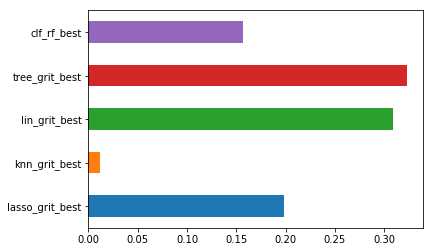

In [120]:
pd.Series(clf_rf.feature_importances_.flatten(), index=X_train_meta.columns).plot(kind='barh')

### Снова обучаем гипер модель, только теперь на LinearRegression

In [126]:
clf_lr_meta = LinearRegression(n_jobs=-1)
clf_lr_meta.fit(X_train_meta, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [127]:
yl_pred_meta_test = clf_rf.predict(X_test_meta)
lin_mse = mean_squared_error(y_train, yl_pred_meta_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

64202.36346929384

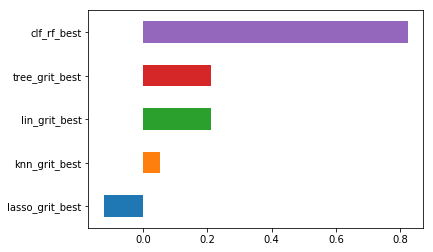

In [128]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_train_meta.columns).plot(kind='barh')

### Объединяем в таблицу и сохраняем для kaggle

In [129]:
sample.head() # пример оформления

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [368]:
len(y_pred_22)

1459

In [369]:
data_test = pd.read_csv('test.csv')
data_test.shape[0]

1459

In [370]:
data_finish = data_test['Id'].copy()
data_finish = pd.DataFrame(data_finish)
data_finish['SalePrice'] = y_pred_22

In [371]:
data_finish.head()

,Id,SalePrice
0,1461,208500.046875
1,1462,181500.046875
2,1463,223500.015625
3,1464,139999.968750
4,1465,250000.031250


In [372]:
data_finish.to_csv('finish.csv', index=False)

# XGBoost

In [139]:
data_train = pd.read_csv('train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [140]:
data_test = pd.read_csv('test.csv')
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [141]:
data_train = data_train[ pd.isnull( data_train['Exterior1st'] ) == 0 ]
data_train = data_train[ pd.isnull( data_train['Electrical'] ) == 0 ]
data_train = data_train[ pd.isnull( data_train['KitchenQual'] ) == 0 ]
data_train = data_train[ pd.isnull( data_train['Utilities'] ) == 0 ]
data_train = data_train[ pd.isnull( data_train['SaleType'] ) == 0 ]

In [142]:
data_test.shape

(1459, 80)

In [145]:
data_test['is_test'] = 1
data_train['is_test'] = 0
data = pd.concat([data_train, data_test])

In [146]:
data[data['is_test'] == 1].shape

(1459, 82)

In [147]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
# Разбиваем данные на категориальные и инт
data_cat = data[cat_feat]

data_int = data.drop(cat_feat, axis=1)
data_int = data_int.drop('SalePrice', axis=1)

In [148]:
data_cat.head()

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,NaN,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,...,NaN,CollgCr,Y,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
1,NaN,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,...,NaN,Veenker,Y,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
2,NaN,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,...,NaN,CollgCr,Y,NaN,CompShg,Gable,Normal,WD,Pave,AllPub
3,NaN,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,...,NaN,Crawfor,Y,NaN,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,NaN,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,...,NaN,NoRidge,Y,NaN,CompShg,Gable,Normal,WD,Pave,AllPub


In [149]:
data.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 1458
Data columns (total 82 columns):
1stFlrSF         2918 non-null int64
2ndFlrSF         2918 non-null int64
3SsnPorch        2918 non-null int64
Alley            198 non-null object
BedroomAbvGr     2918 non-null int64
BldgType         2918 non-null object
BsmtCond         2836 non-null object
BsmtExposure     2836 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2839 non-null object
BsmtFinType2     2838 non-null object
BsmtFullBath     2916 non-null float64
BsmtHalfBath     2916 non-null float64
BsmtQual         2837 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2918 non-null object
Condition1       2918 non-null object
Condition2       2918 non-null object
Electrical       2918 non-null object
EnclosedPorch    2918 non-null int64
ExterCond        2918 non-null object
ExterQual        2918 non-null object
Exterior1st      291

In [150]:
data[data_cat.columns] = data[data_cat.columns].fillna('NaN')
data[data_int.columns] = data[data_int.columns].fillna(0)

In [151]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in data_cat.columns:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [152]:
cat__ = list(data.dtypes[data.dtypes == 'uint8'].index)
data[cat__] = data[cat__].astype(int)

In [153]:
# делим данные на трейн и тест
df_train = data[data.is_test==0]
df_test = data[data.is_test==1]

df_train = df_train.drop('is_test', axis=1)
df_test = df_test.drop('is_test', axis=1)

In [154]:
y_train = df_train['SalePrice'].copy()

df_train = df_train.drop('SalePrice', axis=1)
df_test = df_test.drop('SalePrice', axis=1)

df_train.shape, df_test.shape

((1459, 211), (1459, 211))

In [155]:
df_test.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32')], dtype=object)

## Start model

In [156]:
import xgboost as xgb

In [230]:
xgb.XGBRegressor?
#    ['max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='reg:linear'", 
# "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 
# 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 
# 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None', '**kwargs']

In [347]:
dtrain = xgb.DMatrix(df_train, y_train)
dtest = xgb.DMatrix(df_test)

In [176]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [273]:
xgb_model_2 = xgb.XGBRegressor(n_estimators=30, n_jobs=-1)

In [253]:
max_depth = [2, 5, 7, 9]
colsample_bytree = [0.3, 0.6, 0.9, 1]
subsample = [0.3, 0.6, 0.9, 1]
gamma = [0, 0.3, 0.6, 0.8, 1]
alpha = [0, 0.3, 0.6, 0.9]
lamba = [0.1, 0.3, 0.6, 0.8, 1]

params = {
    'max_depth' : max_depth,
    'colsample_bytree' : colsample_bytree,
    'subsample' : subsample,
    'gamma' : gamma,
    'reg_alpha' : alpha,
    'reg_lambda' : lamba
}

In [254]:
gr_xgb = GridSearchCV(xgb_model_2, params, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')

In [255]:
xgb_model = gr_xgb.fit(df_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [256]:
np.sqrt(abs(xgb_model.best_score_))

36923.41468854034

In [257]:
xgb_model.best_params_
# 'colsample_bytree': 1,
#  'gamma': 0,
#  'max_depth': 5,
#  'reg_alpha': 0.6,
#  'reg_lambda': 0.1,
#  'subsample': 0.9

{'colsample_bytree': 1,
 'gamma': 0,
 'max_depth': 5,
 'reg_alpha': 0.6,
 'reg_lambda': 0.1,
 'subsample': 0.9}

In [258]:
xgb_model_final = xgb.XGBRegressor(colsample_bytree=1, gamma=0, max_depth=5, reg_alpha=0.6, reg_lambda=0.1,
                                   subsample=0.9, n_jobs=-1, n_estimators=1000, learning_rate=0.01)

In [259]:
xgb_model_final.fit(df_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.6, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [261]:
y_pred = xgb_model_final.predict(df_train)

In [263]:
np.sqrt(mean_squared_error(y_pred, y_train))

7014.053393119472

In [264]:
y_pred_xgb_1 = xgb_model_final.predict(df_test)

In [265]:
y_pred_xgb_1

array([123820.195, 155606.   , 179463.5  , ..., 167750.9  , 115513.68 ,
       218047.02 ], dtype=float32)

In [315]:
xgb_model_3 = xgb.XGBRegressor(colsample_bytree=1, gamma=0, reg_alpha=0.6, reg_lambda=0.1,
                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.1)


learning_rate = [0.005, 0.007, 0.01]

fit_params={"early_stopping_rounds":50, 
            "eval_metric" : "rmse", 
            "eval_set" : [[df_train, y_train]]}

params = {
    'learning_rate' : learning_rate
}

In [316]:
gr_xgb_ = GridSearchCV(xgb_model_3, params, fit_params=fit_params, n_jobs=-1, cv=10, 
                       scoring='neg_mean_squared_error')

In [317]:
gr_xgb_.fit(df_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[0]	validation_0-rmse:196280
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:194973
[2]	validation_0-rmse:193668
[3]	validation_0-rmse:192368
[4]	validation_0-rmse:191079


C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[5]	validation_0-rmse:189803
[6]	validation_0-rmse:188538
[7]	validation_0-rmse:187279
[8]	validation_0-rmse:186029
[9]	validation_0-rmse:184793
[10]	validation_0-rmse:183565
[11]	validation_0-rmse:182341
[12]	validation_0-rmse:181133
[13]	validation_0-rmse:179939
[14]	validation_0-rmse:178742
[15]	validation_0-rmse:177551
[16]	validation_0-rmse:176373
[17]	validation_0-rmse:175204
[18]	validation_0-rmse:174049
[19]	validation_0-rmse:172897
[20]	validation_0-rmse:171754
[21]	validation_0-rmse:170616
[22]	validation_0-rmse:169494
[23]	validation_0-rmse:168382
[24]	validation_0-rmse:167280
[25]	validation_0-rmse:166181
[26]	validation_0-rmse:165082
[27]	validation_0-rmse:163995
[28]	validation_0-rmse:162908
[29]	validation_0-rmse:161838
[30]	validation_0-rmse:160771
[31]	validation_0-rmse:159711
[32]	validation_0-rmse:158663
[33]	validation_0-rmse:157623
[34]	validation_0-rmse:156587
[35]	validation_0-rmse:155558
[36]	validation_0-rmse:154538
[37]	validation_0-rmse:153526
[38]	validation

[268]	validation_0-rmse:40923.6
[269]	validation_0-rmse:40743.4
[270]	validation_0-rmse:40569.5
[271]	validation_0-rmse:40396.9
[272]	validation_0-rmse:40222.1
[273]	validation_0-rmse:40041.8
[274]	validation_0-rmse:39874.2
[275]	validation_0-rmse:39701.7
[276]	validation_0-rmse:39527.9
[277]	validation_0-rmse:39361.4
[278]	validation_0-rmse:39194.6
[279]	validation_0-rmse:39028.1
[280]	validation_0-rmse:38860
[281]	validation_0-rmse:38698.8
[282]	validation_0-rmse:38540.9
[283]	validation_0-rmse:38377
[284]	validation_0-rmse:38216.9
[285]	validation_0-rmse:38057.8
[286]	validation_0-rmse:37898.1
[287]	validation_0-rmse:37745
[288]	validation_0-rmse:37592.6
[289]	validation_0-rmse:37436.5
[290]	validation_0-rmse:37287.9
[291]	validation_0-rmse:37138.4
[292]	validation_0-rmse:36986.1
[293]	validation_0-rmse:36841.8
[294]	validation_0-rmse:36695.8
[295]	validation_0-rmse:36549.8
[296]	validation_0-rmse:36405
[297]	validation_0-rmse:36266
[298]	validation_0-rmse:36126.6
[299]	validation_0

[526]	validation_0-rmse:21289
[527]	validation_0-rmse:21261.4
[528]	validation_0-rmse:21233
[529]	validation_0-rmse:21210.5
[530]	validation_0-rmse:21184.5
[531]	validation_0-rmse:21161.3
[532]	validation_0-rmse:21136
[533]	validation_0-rmse:21109.5
[534]	validation_0-rmse:21084.3
[535]	validation_0-rmse:21064.2
[536]	validation_0-rmse:21039.7
[537]	validation_0-rmse:21017.5
[538]	validation_0-rmse:20996
[539]	validation_0-rmse:20972.2
[540]	validation_0-rmse:20950.3
[541]	validation_0-rmse:20925.2
[542]	validation_0-rmse:20902.1
[543]	validation_0-rmse:20879.7
[544]	validation_0-rmse:20859.8
[545]	validation_0-rmse:20837
[546]	validation_0-rmse:20815.9
[547]	validation_0-rmse:20792.4
[548]	validation_0-rmse:20769.4
[549]	validation_0-rmse:20747
[550]	validation_0-rmse:20723.6
[551]	validation_0-rmse:20701.8
[552]	validation_0-rmse:20680.5
[553]	validation_0-rmse:20658.3
[554]	validation_0-rmse:20634.5
[555]	validation_0-rmse:20612.9
[556]	validation_0-rmse:20591.1
[557]	validation_0-r

[784]	validation_0-rmse:17671.6
[785]	validation_0-rmse:17662.6
[786]	validation_0-rmse:17656.6
[787]	validation_0-rmse:17649.1
[788]	validation_0-rmse:17638.1
[789]	validation_0-rmse:17632
[790]	validation_0-rmse:17625.3
[791]	validation_0-rmse:17618.1
[792]	validation_0-rmse:17612.8
[793]	validation_0-rmse:17602
[794]	validation_0-rmse:17592.8
[795]	validation_0-rmse:17584.3
[796]	validation_0-rmse:17575.3
[797]	validation_0-rmse:17567.4
[798]	validation_0-rmse:17557.7
[799]	validation_0-rmse:17550.6
[800]	validation_0-rmse:17542.9
[801]	validation_0-rmse:17535.3
[802]	validation_0-rmse:17525.6
[803]	validation_0-rmse:17514
[804]	validation_0-rmse:17508.1
[805]	validation_0-rmse:17500.1
[806]	validation_0-rmse:17494.5
[807]	validation_0-rmse:17484.4
[808]	validation_0-rmse:17479.4
[809]	validation_0-rmse:17471.7
[810]	validation_0-rmse:17465.3
[811]	validation_0-rmse:17456.4
[812]	validation_0-rmse:17450.5
[813]	validation_0-rmse:17443.2
[814]	validation_0-rmse:17436.1
[815]	validati

[1041]	validation_0-rmse:15961.4
[1042]	validation_0-rmse:15956.1
[1043]	validation_0-rmse:15949.7
[1044]	validation_0-rmse:15946.1
[1045]	validation_0-rmse:15941.5
[1046]	validation_0-rmse:15938
[1047]	validation_0-rmse:15933.8
[1048]	validation_0-rmse:15929.2
[1049]	validation_0-rmse:15923.3
[1050]	validation_0-rmse:15919.3
[1051]	validation_0-rmse:15916.7
[1052]	validation_0-rmse:15912.1
[1053]	validation_0-rmse:15907.1
[1054]	validation_0-rmse:15901.1
[1055]	validation_0-rmse:15896.6
[1056]	validation_0-rmse:15892.5
[1057]	validation_0-rmse:15885.2
[1058]	validation_0-rmse:15880.3
[1059]	validation_0-rmse:15876.3
[1060]	validation_0-rmse:15872
[1061]	validation_0-rmse:15866
[1062]	validation_0-rmse:15860.7
[1063]	validation_0-rmse:15853.9
[1064]	validation_0-rmse:15850.7
[1065]	validation_0-rmse:15843.6
[1066]	validation_0-rmse:15838.8
[1067]	validation_0-rmse:15829.9
[1068]	validation_0-rmse:15824
[1069]	validation_0-rmse:15816.3
[1070]	validation_0-rmse:15812.8
[1071]	validation_

[1291]	validation_0-rmse:14884
[1292]	validation_0-rmse:14882.1
[1293]	validation_0-rmse:14876.8
[1294]	validation_0-rmse:14872.4
[1295]	validation_0-rmse:14866
[1296]	validation_0-rmse:14863.5
[1297]	validation_0-rmse:14857.8
[1298]	validation_0-rmse:14854.1
[1299]	validation_0-rmse:14852.2
[1300]	validation_0-rmse:14849.3
[1301]	validation_0-rmse:14847.4
[1302]	validation_0-rmse:14845.4
[1303]	validation_0-rmse:14840.9
[1304]	validation_0-rmse:14836.1
[1305]	validation_0-rmse:14831.5
[1306]	validation_0-rmse:14828.7
[1307]	validation_0-rmse:14826.4
[1308]	validation_0-rmse:14824.5
[1309]	validation_0-rmse:14822.4
[1310]	validation_0-rmse:14818.7
[1311]	validation_0-rmse:14813.2
[1312]	validation_0-rmse:14810.7
[1313]	validation_0-rmse:14804.1
[1314]	validation_0-rmse:14801.7
[1315]	validation_0-rmse:14797.5
[1316]	validation_0-rmse:14793.3
[1317]	validation_0-rmse:14787.4
[1318]	validation_0-rmse:14783.6
[1319]	validation_0-rmse:14779.2
[1320]	validation_0-rmse:14776.1
[1321]	validat

[1541]	validation_0-rmse:13983.1
[1542]	validation_0-rmse:13980.8
[1543]	validation_0-rmse:13978.8
[1544]	validation_0-rmse:13974.8
[1545]	validation_0-rmse:13971.1
[1546]	validation_0-rmse:13968.7
[1547]	validation_0-rmse:13966.3
[1548]	validation_0-rmse:13964.1
[1549]	validation_0-rmse:13960
[1550]	validation_0-rmse:13957.9
[1551]	validation_0-rmse:13955.7
[1552]	validation_0-rmse:13954.3
[1553]	validation_0-rmse:13952.9
[1554]	validation_0-rmse:13950.5
[1555]	validation_0-rmse:13945.5
[1556]	validation_0-rmse:13944
[1557]	validation_0-rmse:13942.8
[1558]	validation_0-rmse:13940.6
[1559]	validation_0-rmse:13938.1
[1560]	validation_0-rmse:13934.7
[1561]	validation_0-rmse:13931.5
[1562]	validation_0-rmse:13928.4
[1563]	validation_0-rmse:13924.7
[1564]	validation_0-rmse:13923.2
[1565]	validation_0-rmse:13921.7
[1566]	validation_0-rmse:13917.8
[1567]	validation_0-rmse:13915.6
[1568]	validation_0-rmse:13913
[1569]	validation_0-rmse:13911.3
[1570]	validation_0-rmse:13908.9
[1571]	validatio

[1792]	validation_0-rmse:13266.7
[1793]	validation_0-rmse:13264.5
[1794]	validation_0-rmse:13261.5
[1795]	validation_0-rmse:13258.7
[1796]	validation_0-rmse:13255.9
[1797]	validation_0-rmse:13254.3
[1798]	validation_0-rmse:13252.2
[1799]	validation_0-rmse:13250.2
[1800]	validation_0-rmse:13247
[1801]	validation_0-rmse:13244.1
[1802]	validation_0-rmse:13242.3
[1803]	validation_0-rmse:13240.9
[1804]	validation_0-rmse:13239.3
[1805]	validation_0-rmse:13237.5
[1806]	validation_0-rmse:13235.1
[1807]	validation_0-rmse:13233.7
[1808]	validation_0-rmse:13232.8
[1809]	validation_0-rmse:13230.8
[1810]	validation_0-rmse:13226.6
[1811]	validation_0-rmse:13224.4
[1812]	validation_0-rmse:13222.4
[1813]	validation_0-rmse:13219
[1814]	validation_0-rmse:13215
[1815]	validation_0-rmse:13210
[1816]	validation_0-rmse:13208.9
[1817]	validation_0-rmse:13206.9
[1818]	validation_0-rmse:13203.2
[1819]	validation_0-rmse:13200.8
[1820]	validation_0-rmse:13196.5
[1821]	validation_0-rmse:13195.7
[1822]	validation_

[2042]	validation_0-rmse:12612
[2043]	validation_0-rmse:12611.1
[2044]	validation_0-rmse:12609.2
[2045]	validation_0-rmse:12605.5
[2046]	validation_0-rmse:12604.2
[2047]	validation_0-rmse:12601.6
[2048]	validation_0-rmse:12600
[2049]	validation_0-rmse:12597.7
[2050]	validation_0-rmse:12592.7
[2051]	validation_0-rmse:12591.2
[2052]	validation_0-rmse:12586.6
[2053]	validation_0-rmse:12583.8
[2054]	validation_0-rmse:12582.1
[2055]	validation_0-rmse:12581.1
[2056]	validation_0-rmse:12578.3
[2057]	validation_0-rmse:12576.2
[2058]	validation_0-rmse:12574.4
[2059]	validation_0-rmse:12571.2
[2060]	validation_0-rmse:12566.6
[2061]	validation_0-rmse:12562.1
[2062]	validation_0-rmse:12560.4
[2063]	validation_0-rmse:12558.4
[2064]	validation_0-rmse:12554.8
[2065]	validation_0-rmse:12552.1
[2066]	validation_0-rmse:12548.9
[2067]	validation_0-rmse:12545.6
[2068]	validation_0-rmse:12542.8
[2069]	validation_0-rmse:12540.6
[2070]	validation_0-rmse:12539.4
[2071]	validation_0-rmse:12536.8
[2072]	validat

[2292]	validation_0-rmse:12040.3
[2293]	validation_0-rmse:12038.1
[2294]	validation_0-rmse:12035.4
[2295]	validation_0-rmse:12033
[2296]	validation_0-rmse:12030.3
[2297]	validation_0-rmse:12028.2
[2298]	validation_0-rmse:12024.7
[2299]	validation_0-rmse:12022.2
[2300]	validation_0-rmse:12020.2
[2301]	validation_0-rmse:12016.9
[2302]	validation_0-rmse:12014.5
[2303]	validation_0-rmse:12011.9
[2304]	validation_0-rmse:12011.2
[2305]	validation_0-rmse:12010.2
[2306]	validation_0-rmse:12009.5
[2307]	validation_0-rmse:12007.5
[2308]	validation_0-rmse:12006
[2309]	validation_0-rmse:12003.8
[2310]	validation_0-rmse:12001.7
[2311]	validation_0-rmse:11999.6
[2312]	validation_0-rmse:11998.8
[2313]	validation_0-rmse:11996.7
[2314]	validation_0-rmse:11995.3
[2315]	validation_0-rmse:11993.6
[2316]	validation_0-rmse:11991.8
[2317]	validation_0-rmse:11989.9
[2318]	validation_0-rmse:11988.4
[2319]	validation_0-rmse:11986.4
[2320]	validation_0-rmse:11984
[2321]	validation_0-rmse:11981.6
[2322]	validatio

[2543]	validation_0-rmse:11534.5
[2544]	validation_0-rmse:11531.3
[2545]	validation_0-rmse:11529.2
[2546]	validation_0-rmse:11527.4
[2547]	validation_0-rmse:11524.5
[2548]	validation_0-rmse:11522.4
[2549]	validation_0-rmse:11520.2
[2550]	validation_0-rmse:11517.3
[2551]	validation_0-rmse:11515.2
[2552]	validation_0-rmse:11512.4
[2553]	validation_0-rmse:11511.8
[2554]	validation_0-rmse:11510.8
[2555]	validation_0-rmse:11508.6
[2556]	validation_0-rmse:11505.8
[2557]	validation_0-rmse:11504.2
[2558]	validation_0-rmse:11502.7
[2559]	validation_0-rmse:11500.5
[2560]	validation_0-rmse:11499.3
[2561]	validation_0-rmse:11497.2
[2562]	validation_0-rmse:11494.5
[2563]	validation_0-rmse:11493.2
[2564]	validation_0-rmse:11491.7
[2565]	validation_0-rmse:11489.6
[2566]	validation_0-rmse:11488.8
[2567]	validation_0-rmse:11486.9
[2568]	validation_0-rmse:11486.2
[2569]	validation_0-rmse:11483.6
[2570]	validation_0-rmse:11481.9
[2571]	validation_0-rmse:11479.6
[2572]	validation_0-rmse:11478
[2573]	valid

[2793]	validation_0-rmse:11057.3
[2794]	validation_0-rmse:11054.7
[2795]	validation_0-rmse:11052.2
[2796]	validation_0-rmse:11051.4
[2797]	validation_0-rmse:11049.6
[2798]	validation_0-rmse:11048.7
[2799]	validation_0-rmse:11047.2
[2800]	validation_0-rmse:11044.8
[2801]	validation_0-rmse:11043
[2802]	validation_0-rmse:11042.5
[2803]	validation_0-rmse:11040.5
[2804]	validation_0-rmse:11039.1
[2805]	validation_0-rmse:11038.5
[2806]	validation_0-rmse:11036.5
[2807]	validation_0-rmse:11033.8
[2808]	validation_0-rmse:11031.9
[2809]	validation_0-rmse:11030.8
[2810]	validation_0-rmse:11029
[2811]	validation_0-rmse:11028.1
[2812]	validation_0-rmse:11026
[2813]	validation_0-rmse:11023.5
[2814]	validation_0-rmse:11021.7
[2815]	validation_0-rmse:11019.1
[2816]	validation_0-rmse:11016.8
[2817]	validation_0-rmse:11015.8
[2818]	validation_0-rmse:11014.5
[2819]	validation_0-rmse:11012.9
[2820]	validation_0-rmse:11009.1
[2821]	validation_0-rmse:11007.3
[2822]	validation_0-rmse:11005.6
[2823]	validatio

[3044]	validation_0-rmse:10597.5
[3045]	validation_0-rmse:10595.4
[3046]	validation_0-rmse:10593
[3047]	validation_0-rmse:10591.1
[3048]	validation_0-rmse:10590.3
[3049]	validation_0-rmse:10588.4
[3050]	validation_0-rmse:10587.5
[3051]	validation_0-rmse:10584.7
[3052]	validation_0-rmse:10583.4
[3053]	validation_0-rmse:10581.8
[3054]	validation_0-rmse:10580.8
[3055]	validation_0-rmse:10578.2
[3056]	validation_0-rmse:10575.3
[3057]	validation_0-rmse:10573.4
[3058]	validation_0-rmse:10571.4
[3059]	validation_0-rmse:10568.8
[3060]	validation_0-rmse:10568.3
[3061]	validation_0-rmse:10566.1
[3062]	validation_0-rmse:10564.9
[3063]	validation_0-rmse:10562.9
[3064]	validation_0-rmse:10561
[3065]	validation_0-rmse:10559.1
[3066]	validation_0-rmse:10557.7
[3067]	validation_0-rmse:10556
[3068]	validation_0-rmse:10554.3
[3069]	validation_0-rmse:10551.6
[3070]	validation_0-rmse:10550.9
[3071]	validation_0-rmse:10550
[3072]	validation_0-rmse:10547.8
[3073]	validation_0-rmse:10545.7
[3074]	validation_

[3294]	validation_0-rmse:10189
[3295]	validation_0-rmse:10187.2
[3296]	validation_0-rmse:10184.8
[3297]	validation_0-rmse:10182.7
[3298]	validation_0-rmse:10180.2
[3299]	validation_0-rmse:10178.3
[3300]	validation_0-rmse:10177.6
[3301]	validation_0-rmse:10175.8
[3302]	validation_0-rmse:10174.3
[3303]	validation_0-rmse:10173.2
[3304]	validation_0-rmse:10171.9
[3305]	validation_0-rmse:10169.7
[3306]	validation_0-rmse:10167.7
[3307]	validation_0-rmse:10166.8
[3308]	validation_0-rmse:10165.6
[3309]	validation_0-rmse:10164.3
[3310]	validation_0-rmse:10162.4
[3311]	validation_0-rmse:10160.8
[3312]	validation_0-rmse:10159.2
[3313]	validation_0-rmse:10157.6
[3314]	validation_0-rmse:10156.2
[3315]	validation_0-rmse:10154.5
[3316]	validation_0-rmse:10152.3
[3317]	validation_0-rmse:10151.1
[3318]	validation_0-rmse:10150.2
[3319]	validation_0-rmse:10148.2
[3320]	validation_0-rmse:10147.2
[3321]	validation_0-rmse:10145.4
[3322]	validation_0-rmse:10144.1
[3323]	validation_0-rmse:10143.4
[3324]	valid

[3544]	validation_0-rmse:9814.4
[3545]	validation_0-rmse:9811.81
[3546]	validation_0-rmse:9810.97
[3547]	validation_0-rmse:9809.41
[3548]	validation_0-rmse:9808.53
[3549]	validation_0-rmse:9806.55
[3550]	validation_0-rmse:9804.65
[3551]	validation_0-rmse:9802.06
[3552]	validation_0-rmse:9799.91
[3553]	validation_0-rmse:9797.25
[3554]	validation_0-rmse:9795.24
[3555]	validation_0-rmse:9793.32
[3556]	validation_0-rmse:9792.89
[3557]	validation_0-rmse:9789.73
[3558]	validation_0-rmse:9788.06
[3559]	validation_0-rmse:9787.69
[3560]	validation_0-rmse:9786.84
[3561]	validation_0-rmse:9784.61
[3562]	validation_0-rmse:9783.81
[3563]	validation_0-rmse:9782.67
[3564]	validation_0-rmse:9781.25
[3565]	validation_0-rmse:9780.65
[3566]	validation_0-rmse:9779.85
[3567]	validation_0-rmse:9778.3
[3568]	validation_0-rmse:9777.92
[3569]	validation_0-rmse:9777.29
[3570]	validation_0-rmse:9775.77
[3571]	validation_0-rmse:9774.37
[3572]	validation_0-rmse:9773.39
[3573]	validation_0-rmse:9772.61
[3574]	valid

[3793]	validation_0-rmse:9455
[3794]	validation_0-rmse:9452.98
[3795]	validation_0-rmse:9451.15
[3796]	validation_0-rmse:9449.74
[3797]	validation_0-rmse:9448.15
[3798]	validation_0-rmse:9446.37
[3799]	validation_0-rmse:9445.74
[3800]	validation_0-rmse:9443.78
[3801]	validation_0-rmse:9442.59
[3802]	validation_0-rmse:9441.93
[3803]	validation_0-rmse:9439.92
[3804]	validation_0-rmse:9438.4
[3805]	validation_0-rmse:9436.7
[3806]	validation_0-rmse:9435.81
[3807]	validation_0-rmse:9433.78
[3808]	validation_0-rmse:9432.54
[3809]	validation_0-rmse:9430.99
[3810]	validation_0-rmse:9428.33
[3811]	validation_0-rmse:9427.88
[3812]	validation_0-rmse:9425.69
[3813]	validation_0-rmse:9425.15
[3814]	validation_0-rmse:9424.34
[3815]	validation_0-rmse:9422.62
[3816]	validation_0-rmse:9421.23
[3817]	validation_0-rmse:9420.03
[3818]	validation_0-rmse:9417.42
[3819]	validation_0-rmse:9415.43
[3820]	validation_0-rmse:9412.91
[3821]	validation_0-rmse:9411.94
[3822]	validation_0-rmse:9411.33
[3823]	validati

[4043]	validation_0-rmse:9121.21
[4044]	validation_0-rmse:9119.88
[4045]	validation_0-rmse:9119.52
[4046]	validation_0-rmse:9118.44
[4047]	validation_0-rmse:9117.48
[4048]	validation_0-rmse:9115.84
[4049]	validation_0-rmse:9114.34
[4050]	validation_0-rmse:9113.63
[4051]	validation_0-rmse:9113.34
[4052]	validation_0-rmse:9111.42
[4053]	validation_0-rmse:9108.88
[4054]	validation_0-rmse:9107.91
[4055]	validation_0-rmse:9106.51
[4056]	validation_0-rmse:9105.03
[4057]	validation_0-rmse:9103.54
[4058]	validation_0-rmse:9101.08
[4059]	validation_0-rmse:9099.29
[4060]	validation_0-rmse:9098.14
[4061]	validation_0-rmse:9096.86
[4062]	validation_0-rmse:9094.8
[4063]	validation_0-rmse:9093.5
[4064]	validation_0-rmse:9091.7
[4065]	validation_0-rmse:9091.24
[4066]	validation_0-rmse:9089.44
[4067]	validation_0-rmse:9089.1
[4068]	validation_0-rmse:9087.72
[4069]	validation_0-rmse:9086.21
[4070]	validation_0-rmse:9085.24
[4071]	validation_0-rmse:9083.74
[4072]	validation_0-rmse:9083.08
[4073]	validat

[4293]	validation_0-rmse:8783.62
[4294]	validation_0-rmse:8782.47
[4295]	validation_0-rmse:8781.68
[4296]	validation_0-rmse:8780.3
[4297]	validation_0-rmse:8779.37
[4298]	validation_0-rmse:8778.16
[4299]	validation_0-rmse:8777.41
[4300]	validation_0-rmse:8776.5
[4301]	validation_0-rmse:8775.2
[4302]	validation_0-rmse:8773.85
[4303]	validation_0-rmse:8772.67
[4304]	validation_0-rmse:8771.92
[4305]	validation_0-rmse:8771.13
[4306]	validation_0-rmse:8770.42
[4307]	validation_0-rmse:8768.86
[4308]	validation_0-rmse:8767.37
[4309]	validation_0-rmse:8766.14
[4310]	validation_0-rmse:8764.04
[4311]	validation_0-rmse:8762.63
[4312]	validation_0-rmse:8761.23
[4313]	validation_0-rmse:8760.85
[4314]	validation_0-rmse:8759.42
[4315]	validation_0-rmse:8758.53
[4316]	validation_0-rmse:8757.1
[4317]	validation_0-rmse:8755.25
[4318]	validation_0-rmse:8754.17
[4319]	validation_0-rmse:8753.61
[4320]	validation_0-rmse:8752.97
[4321]	validation_0-rmse:8751.51
[4322]	validation_0-rmse:8750.01
[4323]	validat

[4543]	validation_0-rmse:8483.01
[4544]	validation_0-rmse:8481.44
[4545]	validation_0-rmse:8480.27
[4546]	validation_0-rmse:8479.49
[4547]	validation_0-rmse:8477.44
[4548]	validation_0-rmse:8475.2
[4549]	validation_0-rmse:8474.01
[4550]	validation_0-rmse:8473.46
[4551]	validation_0-rmse:8471.82
[4552]	validation_0-rmse:8470.87
[4553]	validation_0-rmse:8470.52
[4554]	validation_0-rmse:8470.09
[4555]	validation_0-rmse:8469.48
[4556]	validation_0-rmse:8468.54
[4557]	validation_0-rmse:8467.23
[4558]	validation_0-rmse:8465.9
[4559]	validation_0-rmse:8464.38
[4560]	validation_0-rmse:8463.33
[4561]	validation_0-rmse:8462.37
[4562]	validation_0-rmse:8461.16
[4563]	validation_0-rmse:8460.75
[4564]	validation_0-rmse:8460.08
[4565]	validation_0-rmse:8458.75
[4566]	validation_0-rmse:8457.9
[4567]	validation_0-rmse:8457.1
[4568]	validation_0-rmse:8455.48
[4569]	validation_0-rmse:8455.24
[4570]	validation_0-rmse:8454.42
[4571]	validation_0-rmse:8453.22
[4572]	validation_0-rmse:8451.8
[4573]	validati

[4793]	validation_0-rmse:8198.31
[4794]	validation_0-rmse:8196.92
[4795]	validation_0-rmse:8195.88
[4796]	validation_0-rmse:8195.2
[4797]	validation_0-rmse:8194.46
[4798]	validation_0-rmse:8193.96
[4799]	validation_0-rmse:8192.95
[4800]	validation_0-rmse:8192.28
[4801]	validation_0-rmse:8191.46
[4802]	validation_0-rmse:8190.53
[4803]	validation_0-rmse:8189.87
[4804]	validation_0-rmse:8189.24
[4805]	validation_0-rmse:8188.56
[4806]	validation_0-rmse:8187.45
[4807]	validation_0-rmse:8186.52
[4808]	validation_0-rmse:8186.13
[4809]	validation_0-rmse:8184.07
[4810]	validation_0-rmse:8182.86
[4811]	validation_0-rmse:8181.61
[4812]	validation_0-rmse:8181.05
[4813]	validation_0-rmse:8180.17
[4814]	validation_0-rmse:8179.48
[4815]	validation_0-rmse:8177.98
[4816]	validation_0-rmse:8177.68
[4817]	validation_0-rmse:8176.71
[4818]	validation_0-rmse:8176.17
[4819]	validation_0-rmse:8174.97
[4820]	validation_0-rmse:8174.57
[4821]	validation_0-rmse:8173.05
[4822]	validation_0-rmse:8172.26
[4823]	vali

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.6, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9),
       fit_params={'early_stopping_rounds': 50, 'eval_metric': 'rmse', 'eval_set': [[      1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtFinSF1  BsmtFinSF2  \
0          856       854          0             3       706.0         0.0
1         1262         0          0             3       978.0       ...
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1459, dtype: float64]]},
       iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.005, 0.007, 0.01]},
       pre_dispatch='2*n_jobs', refit=Tru

In [318]:
xgb_best = gr_xgb_.best_estimator_

In [319]:
y_pred = xgb_best.predict(df_train)

In [321]:
y_pred_xgb_2 = xgb_best.predict(df_test)

In [330]:
print (xgb_best.best_score)
print (xgb_best.best_ntree_limit)
print (gr_xgb_.best_params_)

7977.44873
5000
{'learning_rate': 0.007}


In [362]:
import xgboost as xgb

In [386]:
parametrs = {
    'booster' : 'gbtree',
    'objective' : 'reg:linear',
    "eval_metric" : "rmse",
    'max_depth' : 5,
    'silent': 1,
    'eta': 0.3, 
    'n_jobs': -1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0.6,
    'reg_lambda': 0.1,
    'subsample': 0.9
}

num_rounds = 1000

In [387]:
watchlist  = [(dtrain,'train')]

In [388]:
xgb_model__ = xgb.train(parametrs, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

[0]	train-rmse:140038
Will train until train-rmse hasn't improved in 10 rounds.
[1]	train-rmse:100320
[2]	train-rmse:72322.5
[3]	train-rmse:52903.8
[4]	train-rmse:39495.4
[5]	train-rmse:30490
[6]	train-rmse:24493.5
[7]	train-rmse:20537.8
[8]	train-rmse:17929
[9]	train-rmse:16025.2
[10]	train-rmse:14871.4
[11]	train-rmse:14066.5
[12]	train-rmse:13390.7
[13]	train-rmse:12869.5
[14]	train-rmse:12413.6
[15]	train-rmse:12166.7
[16]	train-rmse:11729.9
[17]	train-rmse:11428.8
[18]	train-rmse:11163.7
[19]	train-rmse:10832
[20]	train-rmse:10579.7
[21]	train-rmse:10276.8
[22]	train-rmse:10079.1
[23]	train-rmse:9851.36
[24]	train-rmse:9708.21
[25]	train-rmse:9468.84
[26]	train-rmse:9320.45
[27]	train-rmse:9238.79
[28]	train-rmse:9039.57
[29]	train-rmse:8781.31
[30]	train-rmse:8562.23
[31]	train-rmse:8407.39
[32]	train-rmse:8295.45
[33]	train-rmse:8135.34
[34]	train-rmse:8010.65
[35]	train-rmse:7783.2
[36]	train-rmse:7668.25
[37]	train-rmse:7506.95
[38]	train-rmse:7422.27
[39]	train-rmse:7257.58
[

[332]	train-rmse:102.077
[333]	train-rmse:99.4261
[334]	train-rmse:98.9763
[335]	train-rmse:96.7102
[336]	train-rmse:95.4155
[337]	train-rmse:93.5756
[338]	train-rmse:92.214
[339]	train-rmse:90.7455
[340]	train-rmse:88.2676
[341]	train-rmse:86.7901
[342]	train-rmse:85.2688
[343]	train-rmse:84.6344
[344]	train-rmse:83.537
[345]	train-rmse:82.4494
[346]	train-rmse:80.8281
[347]	train-rmse:80.4979
[348]	train-rmse:79.7656
[349]	train-rmse:78.936
[350]	train-rmse:77.2246
[351]	train-rmse:76.027
[352]	train-rmse:74.4537
[353]	train-rmse:73.8258
[354]	train-rmse:72.6014
[355]	train-rmse:71.0248
[356]	train-rmse:69.5315
[357]	train-rmse:68.372
[358]	train-rmse:67.3699
[359]	train-rmse:66.5311
[360]	train-rmse:64.6589
[361]	train-rmse:63.5188
[362]	train-rmse:62.6915
[363]	train-rmse:61.6298
[364]	train-rmse:60.7816
[365]	train-rmse:60.1566
[366]	train-rmse:59.7904
[367]	train-rmse:59.3128
[368]	train-rmse:58.6174
[369]	train-rmse:57.7207
[370]	train-rmse:57.1495
[371]	train-rmse:56.7585
[372]

[662]	train-rmse:1.36995
[663]	train-rmse:1.34438
[664]	train-rmse:1.33635
[665]	train-rmse:1.31495
[666]	train-rmse:1.29148
[667]	train-rmse:1.27026
[668]	train-rmse:1.24828
[669]	train-rmse:1.22476
[670]	train-rmse:1.1989
[671]	train-rmse:1.17913
[672]	train-rmse:1.16829
[673]	train-rmse:1.15848
[674]	train-rmse:1.1402
[675]	train-rmse:1.11583
[676]	train-rmse:1.09766
[677]	train-rmse:1.09139
[678]	train-rmse:1.07664
[679]	train-rmse:1.07019
[680]	train-rmse:1.05757
[681]	train-rmse:1.03274
[682]	train-rmse:1.01599
[683]	train-rmse:0.987417
[684]	train-rmse:0.970839
[685]	train-rmse:0.960169
[686]	train-rmse:0.937623
[687]	train-rmse:0.930917
[688]	train-rmse:0.921354
[689]	train-rmse:0.913152
[690]	train-rmse:0.905308
[691]	train-rmse:0.887517
[692]	train-rmse:0.875213
[693]	train-rmse:0.870683
[694]	train-rmse:0.862533
[695]	train-rmse:0.845783
[696]	train-rmse:0.834221
[697]	train-rmse:0.827717
[698]	train-rmse:0.821011
[699]	train-rmse:0.81083
[700]	train-rmse:0.806754
[701]	trai

[980]	train-rmse:0.073337
[981]	train-rmse:0.07325
[982]	train-rmse:0.073111
[983]	train-rmse:0.072957
[984]	train-rmse:0.07295
[985]	train-rmse:0.072873
[986]	train-rmse:0.072626
[987]	train-rmse:0.072575
[988]	train-rmse:0.072568
[989]	train-rmse:0.072543
[990]	train-rmse:0.072346
[991]	train-rmse:0.072183
[992]	train-rmse:0.072093
[993]	train-rmse:0.072066
[994]	train-rmse:0.071896
[995]	train-rmse:0.071909
[996]	train-rmse:0.071671
[997]	train-rmse:0.071667
[998]	train-rmse:0.07163
[999]	train-rmse:0.071532


In [377]:
y_pred_22 = xgb_model__.predict(dtrain)

In [379]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_train, y_pred_22)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.07153208974411952

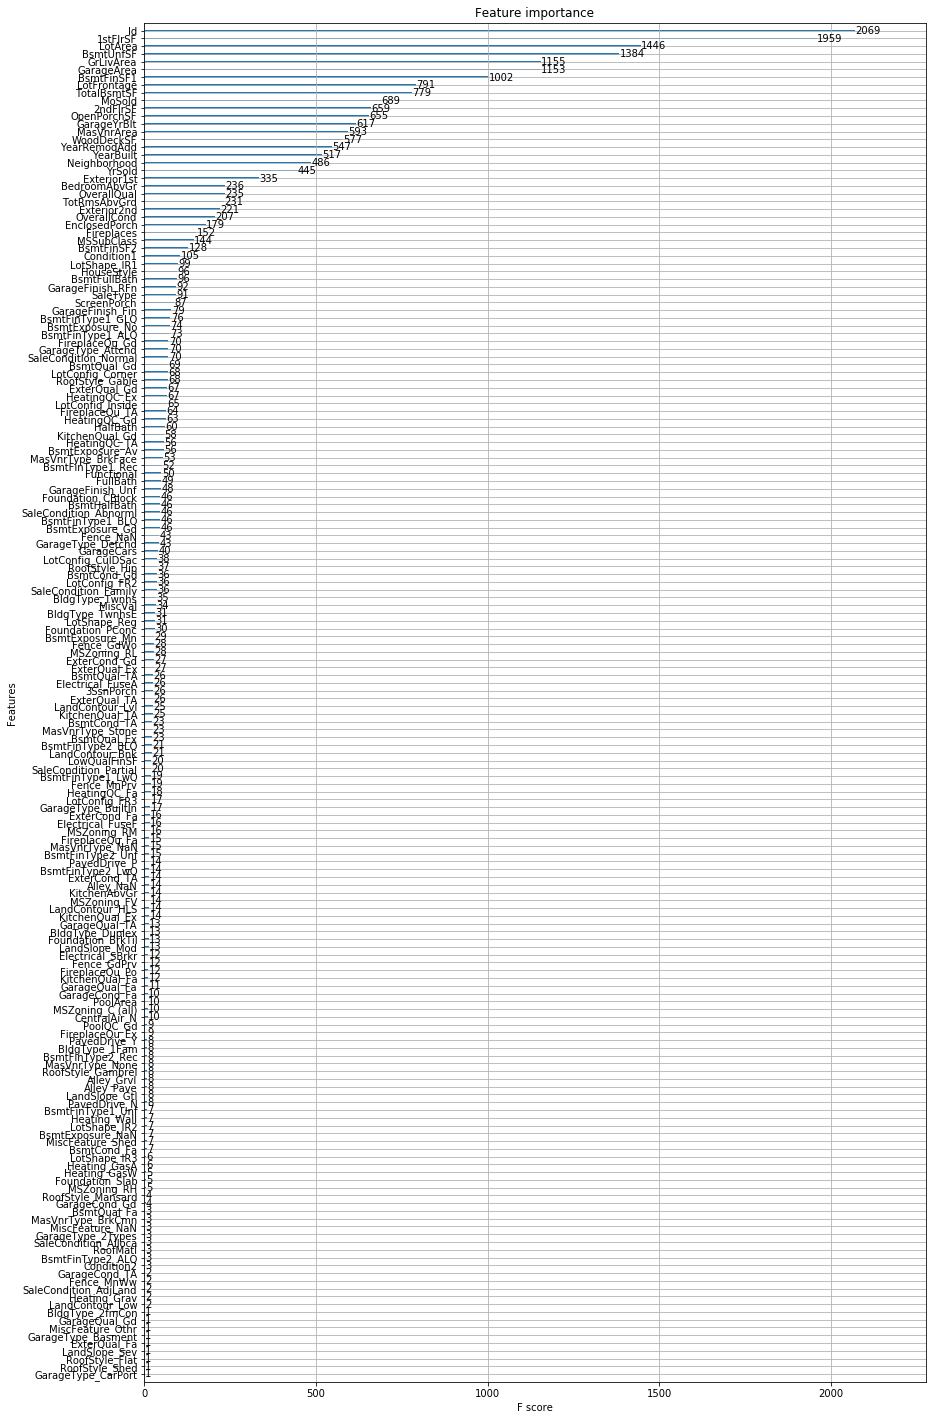

In [367]:
from pylab import rcParams
rcParams['figure.figsize'] = (14, 25)

xgb.plot_importance(xgb_model)

In [167]:
# !!! Финалочка
y_pred_xg = xgb_model.predict(dtrain)

# Catboost

In [1]:
from catboost import CatBoostClassifier

In [7]:
ctb = CatBoostClassifier(random_seed=17)

In [8]:
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
### нужно подделать под даннцые

In [ ]:
from sklearn.model_selection import train_test_split
train_df, y = df.drop('y', axis=1), df['y']
train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df, y, 
                                                                  test_size=.3, stratify=y, 
                                                                  random_state=17)

In [ ]:
cat_features_idx = np.where(train_df_part.dtypes == 'object')[0].tolist()

In [ ]:
%%time
cv_scores = []
for train_idx, test_idx in skf.split(train_df_part, y_train_part):
    cv_train_df, cv_valid_df = train_df_part.iloc[train_idx, :], train_df_part.iloc[test_idx, :]
    y_cv_train, y_cv_valid = y_train_part.iloc[train_idx], y_train_part.iloc[test_idx]
    
    ctb.fit(cv_train_df, y_cv_train,
        cat_features=cat_features_idx);
    
    cv_scores.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df)[:, 1]))

In [ ]:
np.mean(cv_scores)

In [ ]:
%%time
ctb.fit(train_df_part, y_train_part,
        cat_features=cat_features_idx);

In [ ]:
roc_auc_score(y_valid, ctb.predict_proba(valid_df)[:, 1])